# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "arthur"
ln1 = "imbert"
fn2 = "benoit"
ln2 = "robaglia"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_imbert_arthur_and_robaglia_benoit.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [3]:
%matplotlib inline

In [4]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce a class that will be used for the solvers.

In [5]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

In [6]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [7]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation for the least-squares problem

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [8]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation for the logistic regression problem
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [9]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

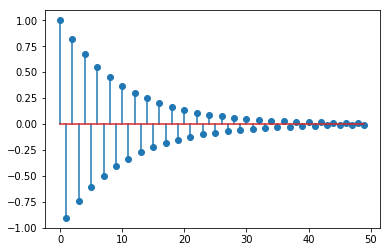

In [10]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [13]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
model = LinReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.718682945995953e-06

In [14]:
lbda = 1. / n ** (0.5)
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)
model = LogReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

3.42718902776823e-07

### Choice of the model

In [55]:
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
model = LinReg(_A, _b, lbda)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)
#model = LogReg(_A, _b, lbda)

### Compute the theoretical step-size for FISTA

In [56]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.75805799484


### Get a very precise minimum to compute distances to minimum

In [57]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

0.522736647448172


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BFGS)

Before implementing GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process.

In [58]:
import time

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [59]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the ISTA solver in the cell below

In [60]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x_new = x - step * grad(x)
        x = x_new.copy()
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [61]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_min, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.83e-01 | 8.27e-01 | 9.9134e-04
      10 | 1.79e-09 | 6.72e-05 | 8.9295e-03
      20 | 1.11e-16 | 7.79e-09 | 1.5831e-02
      30 | 1.11e-16 | 6.83e-11 | 2.2775e-02
      40 | 0.00e+00 | 6.85e-11 | 2.9618e-02


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the FISTA solver in the cell below

In [62]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        x_new = y - step * grad(y)
        t_new = (1 + np.sqrt(1 + 4 * (t**2)) / 2)
        y_new = x_new + (t - 1) * (x_new - x)/ t_new
        x = x_new.copy()
        t = t_new
        y = y_new.copy()
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [63]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.83e-01 | 8.27e-01 | 1.1485e-03
      10 | 6.35e-08 | 3.93e-04 | 9.6407e-03
      20 | 1.02e-12 | 1.61e-06 | 1.8546e-02
      30 | 3.33e-16 | 2.58e-08 | 2.8853e-02
      40 | 2.22e-16 | 2.70e-10 | 4.0497e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [64]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.57e-02 | 2.28e-01 | 1.4721e-02
Optimization terminated successfully.
         Current function value: 0.522737
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [65]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err    |   time  
       0 | 7.24e-01 | 1.31e+00 | 7.4036e-03


### A first numerical comparison of deterministic solvers

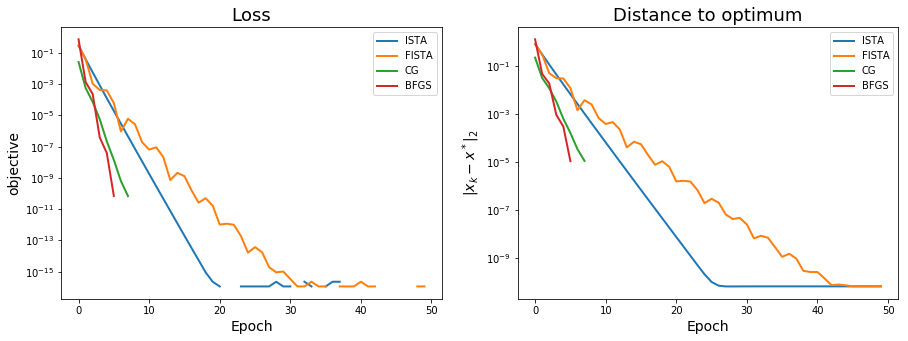

In [66]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

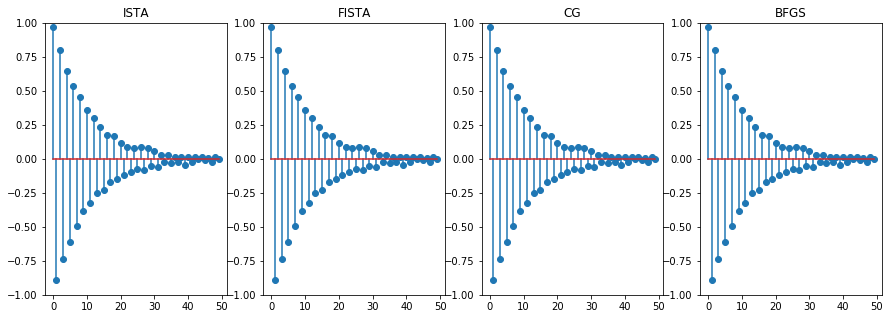

In [67]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here

The equilibrium reached is pretty much the same, but CG and BFGS are much faster than FISTA and ISTA. Moreover, in the logistic case, FISTA is still faster than ISTA though the decrease isn't monotonical. But in the linear case, FISTA is better than ISTA only for the very first iterations. The problem is well conditionned and the loss decreases too much to allow FISTA to keep its advantage.

- What do you observe about FISTA? is it suprising ?

FISTA doesn't monotonically decrease the objective function. It's due to the y update and thus, it's not a descent gradient algorithm ($f(x_{k+1})$ is not necessarily smaller than $f(x_{k})$).

<a id='stoc'></a> 
## 4. Stochastic methods

In [68]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [69]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x -= step * grad_i(i, x) / np.sqrt(idx + 1)
        ### END TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [70]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_min, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err    |   time  
       0 | 4.29e+01 | 8.99e+00 | 9.0613e-03
      10 | 2.63e-02 | 2.30e-01 | 8.6711e-01
      20 | 3.74e-02 | 2.74e-01 | 1.7228e+00
      30 | 3.03e-02 | 2.43e-01 | 2.7284e+00
      40 | 1.91e-02 | 1.97e-01 | 3.7066e+00


We tune the step size by hand.

[]

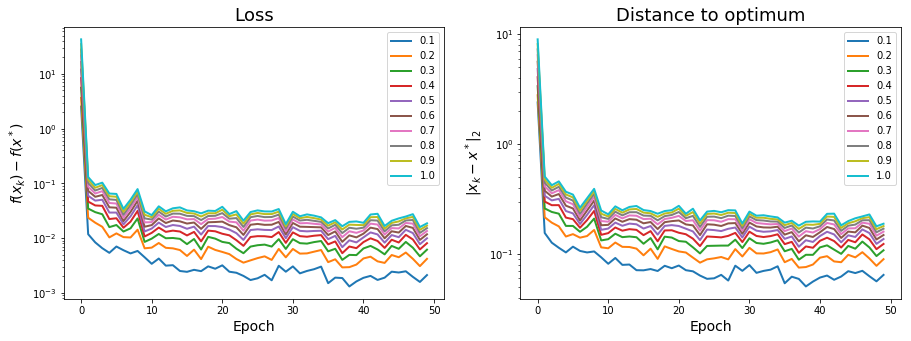

In [71]:
step_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
l_obj = []
l_err = []
for step in step_list:
    # compute SGD
    x_init = np.zeros(d)
    sgd_inspector = inspector(model.loss, x_min, verbose=False)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step, callback=sgd_inspector)
    l_obj.append(sgd_inspector.obj)
    l_err.append(sgd_inspector.err)
    
# plot
stepsize = [str(i) for i in step_list]
plt.figure(figsize=(15, 5))

# loss
plt.subplot(1, 2, 1)
for obj in l_obj:
    plt.semilogy(obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
plt.legend(stepsize)

# distance to optimum
plt.subplot(1, 2, 2)
for err in l_err:
    plt.semilogy(err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(stepsize)

plt.plot()

With a low stepsize, SGD converges better. In the logistic case, it also converges slower.

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [72]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    z = np.zeros(d)
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        z = grad_i(i, x)
        y += (z - gradient_memory[i, :]) / n
        gradient_memory[i, :] = z
        x -= step * y
        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [73]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.26e+00 | 2.30e+00 | 6.9046e-04
      10 | 1.13e-02 | 1.50e-01 | 1.8061e+00
      20 | 2.80e-04 | 2.40e-02 | 3.5892e+00
      30 | 8.42e-06 | 4.09e-03 | 4.8779e+00
      40 | 2.29e-07 | 6.73e-04 | 6.0509e+00


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [74]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        
        ### TODO
        if idx % n == 0:
            x_old = x.copy()
            mu = grad(x_old)
        i = iis[idx]
        x -= step * (grad_i(i, x) - grad_i(i, x_old) + mu)            
        ### END TODO        
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [75]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)
    
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.22e+00 | 2.28e+00 | 8.1635e-04
      10 | 3.78e-05 | 9.03e-03 | 1.1763e+00
      20 | 4.34e-10 | 2.98e-05 | 2.4079e+00
      30 | 4.77e-15 | 9.62e-08 | 4.2010e+00
      40 | 1.11e-16 | 4.44e-10 | 5.8899e+00


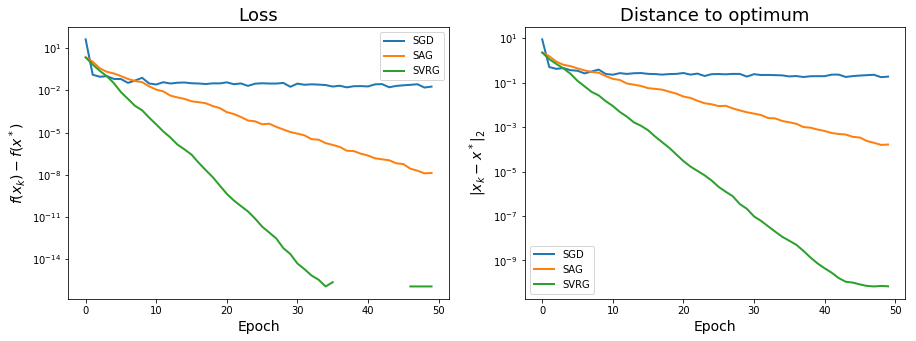

In [76]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

SGD doesn't converge well. There is too much variance. It quickly reaches the area of the equilibrium and it stagnates around it.

<a id='comp'></a> 
## 5. Numerical comparison

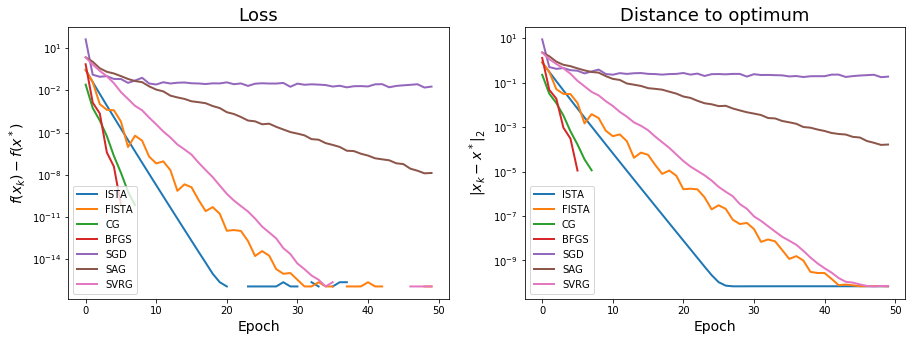

In [77]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

In [103]:
def problem(model, title):
    """
    Function plotting the evolution of the loss and the distance to the minimum according to the type of model
    ----------
    Parameters
    ----------
    model : the type of regression model (linear, logistic)
    title : the title given to the plots
    """
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)

    # ISTA
    step = 1. / model.lipschitz_constant()
    x_init = np.zeros(d)
    ista_inspector = inspector(model.loss, x_min, verbose=False)
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

    # FISTA
    step = 1. / model.lipschitz_constant()
    x_init = np.zeros(d)
    fista_inspector = inspector(model.loss, x_min, verbose=False)
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

    # CG
    x_init = np.zeros(d)
    cg_inspector = inspector(model.loss, x_min, verbose=False)
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

    # BFGS
    x_init = np.zeros(d)
    bfgs_inspector = inspector(model.loss, x_min, verbose=False)
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

    # SGD
    step0 = 0.1
    x_init = np.zeros(d)
    sgd_inspector = inspector(model.loss, x_min, verbose=False)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

    # SAG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
    else:
        step = 1.0 / (max_squared_sum + model.lbda)
    x_init = np.zeros(d)
    sag_inspector = inspector(model.loss, x_min, verbose=False)
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

    # SVRG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
    else:
        step = 1.0 / (max_squared_sum + model.lbda)
    x_init = np.zeros(d)
    svrg_inspector = inspector(model.loss, x_min, verbose=False)    
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

    # plot
    plt.figure(figsize=(15, 5))
    inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
                  sgd_inspector, sag_inspector, svrg_inspector]
    solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    # loss
    plt.subplot(1, 2, 1)
    for insp in inspectors:
        plt.semilogy(insp.obj, lw=2)
        plt.title("Loss" + " " + title, fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.legend(solvers, loc="upper right")

    # distance to optimum
    plt.subplot(1, 2, 2)
    for insp in inspectors:
        plt.semilogy(insp.err, lw=2)
        plt.title("Distance to optimum" + " " + title, fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.legend(solvers, loc="upper right")
    plt.plot()
    
    return

### Compare and comment your results

We compare the performances of algorithms for the linear and the logistic case.

Optimization terminated successfully.
         Current function value: 0.514242
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


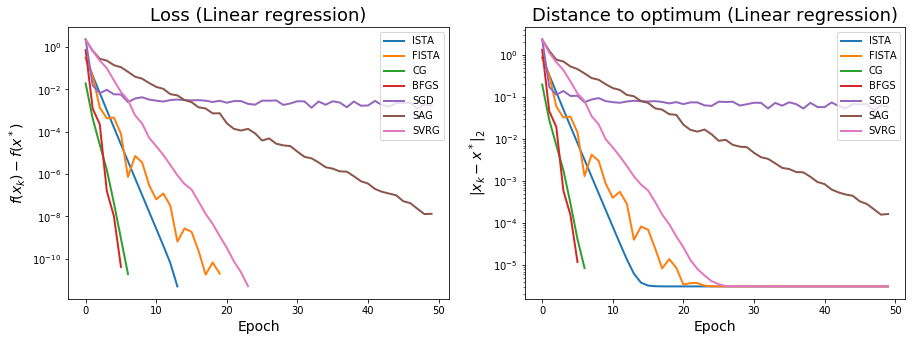

In [124]:
lbda = 1. / n ** (0.5)
corr = 0.1
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(Linear regression)")

We obtain the faster results with BFGS and CG. Even ISTA and FISTA perform well. This problem is obviously well conditionned. Globally, the stochastic algorithms are less efficient. SGD starts fast, but it quickly reaches the area of the equilibrium and it stagnates around it (it may be due to a too large variance).

Optimization terminated successfully.
         Current function value: 0.354636
         Iterations: 9
         Function evaluations: 23
         Gradient evaluations: 23


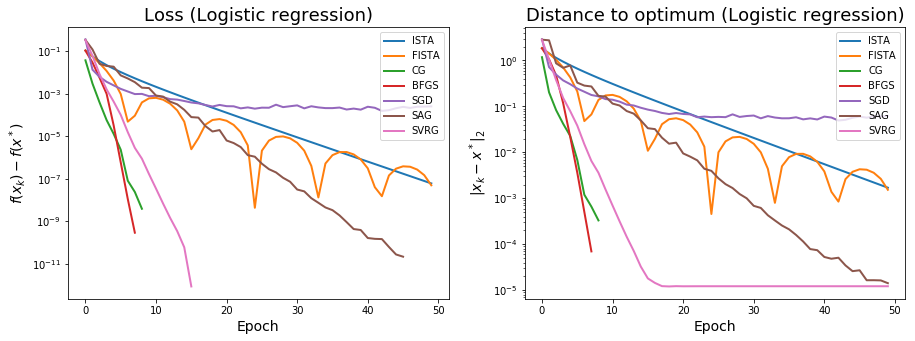

In [126]:
lbda = 1. / n ** (0.5)
corr = 0.1
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=corr)
model = LogReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(Logistic regression)")

In the logistic case, SVRG performs better than ISTA and FISTA. We can clearly observe the non monotically decrease of FISTA. In this case, the stochastic algorithm narrow the gap with the deterministic ones.

### Impact of regularization

Optimization terminated successfully.
         Current function value: 0.493000
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34


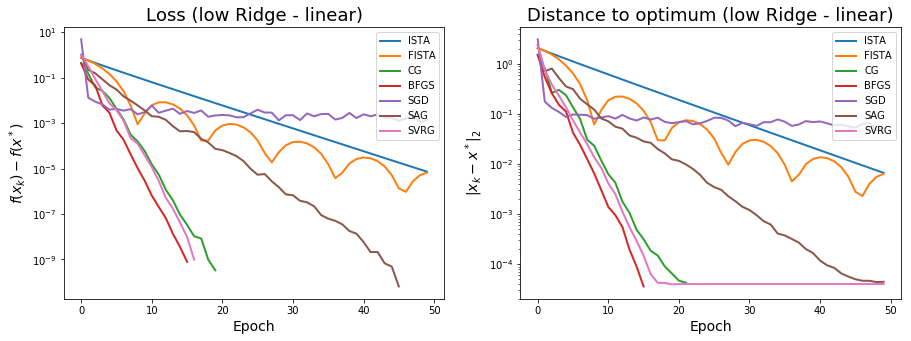

In [127]:
lbda = 1. / n
corr = 0.5
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(low Ridge - linear)")

Optimization terminated successfully.
         Current function value: 0.519296
         Iterations: 20
         Function evaluations: 28
         Gradient evaluations: 28


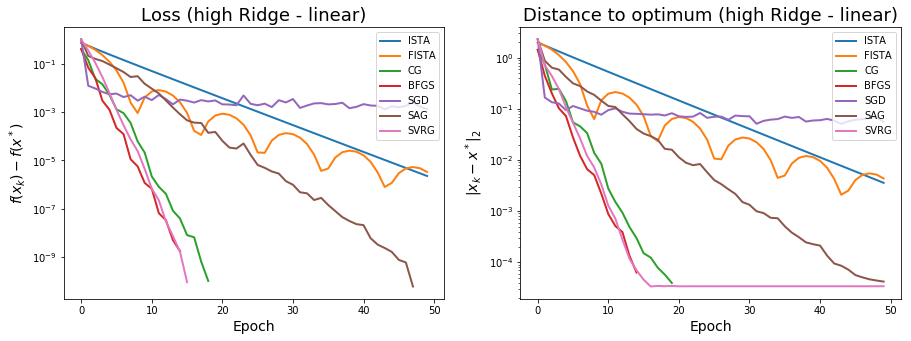

In [128]:
lbda = 1. / n ** (0.5)
corr = 0.5
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(high Ridge - linear)")

Optimization terminated successfully.
         Current function value: 0.405641
         Iterations: 27
         Function evaluations: 65
         Gradient evaluations: 65


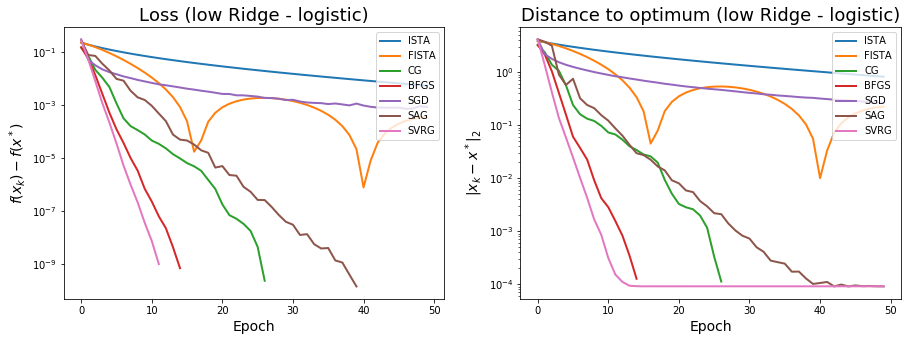

In [129]:
lbda = 1. / n
corr = 0.5
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=corr)
model = LogReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(low Ridge - logistic)")

Optimization terminated successfully.
         Current function value: 0.461074
         Iterations: 16
         Function evaluations: 33
         Gradient evaluations: 33


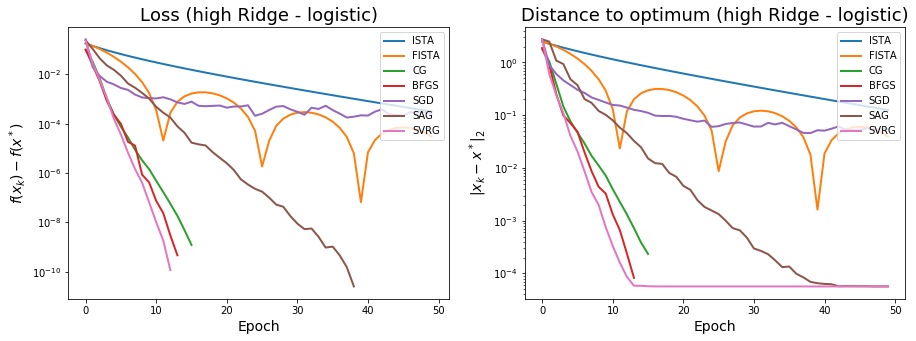

In [130]:
lbda = 1. / n ** (0.5)
corr = 0.5
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=corr)
model = LogReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(high Ridge - logistic)")

ISTA, FISTA and SGD seem slower and less efficient with a low regularization. SVRG and BFGS doesn't seem so much affected by the different level of regularization. On the contrary, in the logistic case, CG returns better results with a low level of regularization (in the logistic case). Moreover, the non monotically decrease of FISTA presents a larger "period" with a low regularization and a logistic framework, making its performances worse.

### Impact of correlation

Optimization terminated successfully.
         Current function value: 0.519105
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


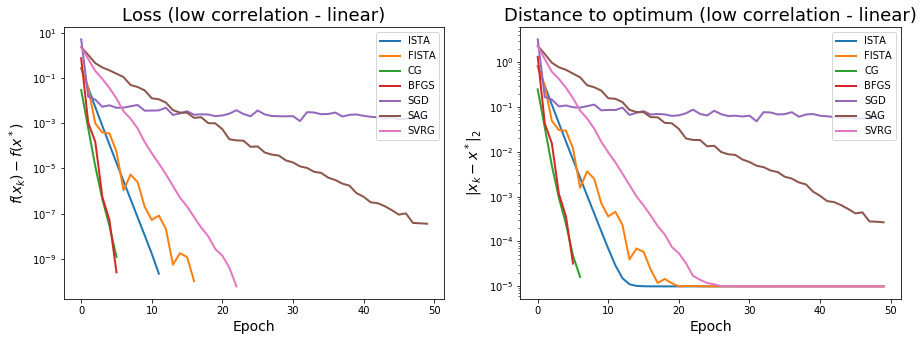

In [131]:
lbda = 1. / n ** (0.5)
corr = 0.1
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(low correlation - linear)")

         Current function value: 0.514051
         Iterations: 50
         Function evaluations: 78
         Gradient evaluations: 78


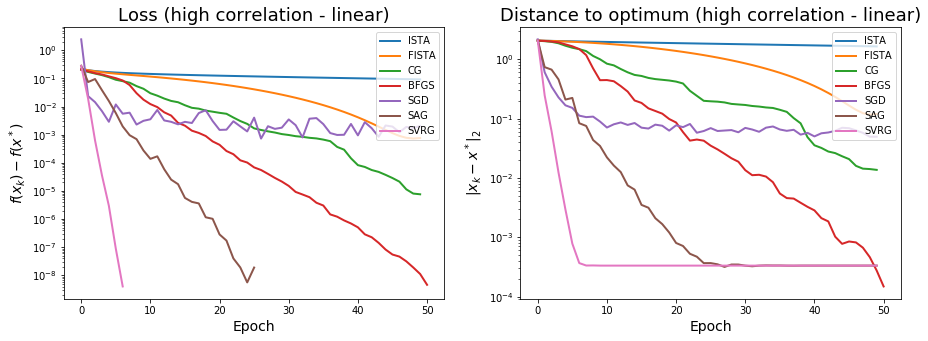

In [132]:
lbda = 1. / n ** (0.5)
corr = 0.9
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(high correlation - linear)")

Optimization terminated successfully.
         Current function value: 0.355423
         Iterations: 9
         Function evaluations: 22
         Gradient evaluations: 22


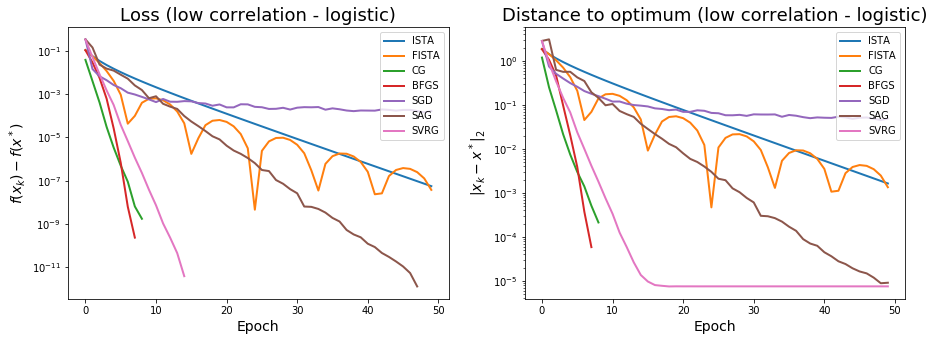

In [133]:
lbda = 1. / n ** (0.5)
corr = 0.1
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=corr)
model = LogReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(low correlation - logistic)")

         Current function value: 0.598084
         Iterations: 50
         Function evaluations: 70
         Gradient evaluations: 70


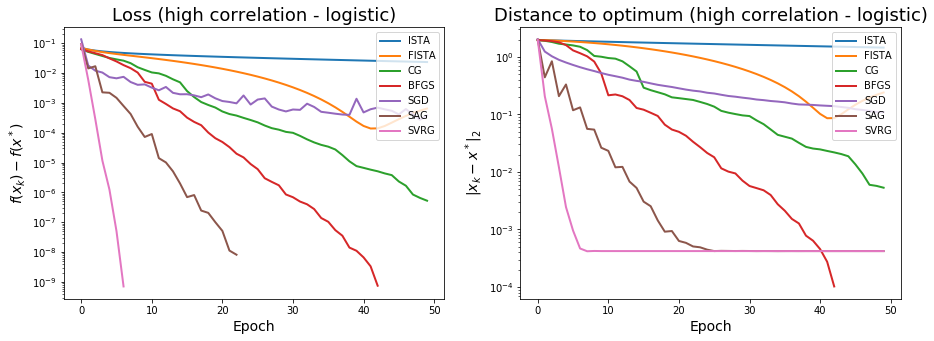

In [134]:
lbda = 1. / n ** (0.5)
corr = 0.9
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=corr)
model = LogReg(_A, _b, lbda)
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
problem(model, title="(high correlation - logistic)")

The stochastic algorithms outperform the deterministic ones with a higher correlation. SAG and SVRG return the best results. SGD still doesn't converge well, but ISTA, FISTA, CG and BFGS are worse. The differences of performance between the deterministic algorithms is more pronounced with a high correlation. Moreover, FISTA outperforms ISTA.

### Conclusion

With a low correlation between the features, the deterministic solvers are more efficient, especially BFGS. However, The stochastic solvers outperforms the latters when the features are highly correlated. The impact of regularization on the algorithms' performances is less obvious. Globally, excepted SVRG, the stochastic solutions are slower and less efficient when the conditionning is great. 